### 1. Setting up plotting code

In [1]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

# codes to aid visual representation taken from Harvard CS109: Data Science
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

def remove_border(axes=None, top=False, right = False, left = True, bottom = True):
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    # now re-enable visibles:
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
pd.set_option('display.width',500)
pd.set_option('display.max_columns',100)

D:\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### 2. Code to draw a choropleth representation of state probability (helpers.py)

In [2]:
# a system to convert state abbreviation to state name
# this is because json file is written with abbreviation
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [3]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py
#load in state geometry

state2poly = defaultdict(list)

data = json.load(file("election_data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

## more code to aid visual representation
def draw_state (plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs,ys = zip(*polygon)
        plot.fill(xs,ys,**kwargs)
    
def make_map(states,label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize = (12, 9))
    ax = plt.gca()
    
    if states.max() < 2: #colormap for election probabilities
        cmap = cm.RdBu # only uses color Red and Blue
        vmin, vmax = 0,1
    else: # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0,states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    # skip some states
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax,state,color=color, ec='k')
    
    #add an inset colorbar
    ax1 = fig.add_axes([0.45,0.70,0.4, 0.02])
    cb1 = mpl.colorbar.ColorbarBase(ax1,cmap=cmap,norm=norm, orientation ='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False,bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180,-60)
    ax.set_ylim(15,75)
    return ax

In [4]:
# build our model 1 month before election time
### build our model 1 month before the election:
import datetime
today = datetime.datetime(2016, 10, 8)


### 3. Electoral votes break down by state 



In [5]:
electoral_votes = pd.read_csv("election_data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


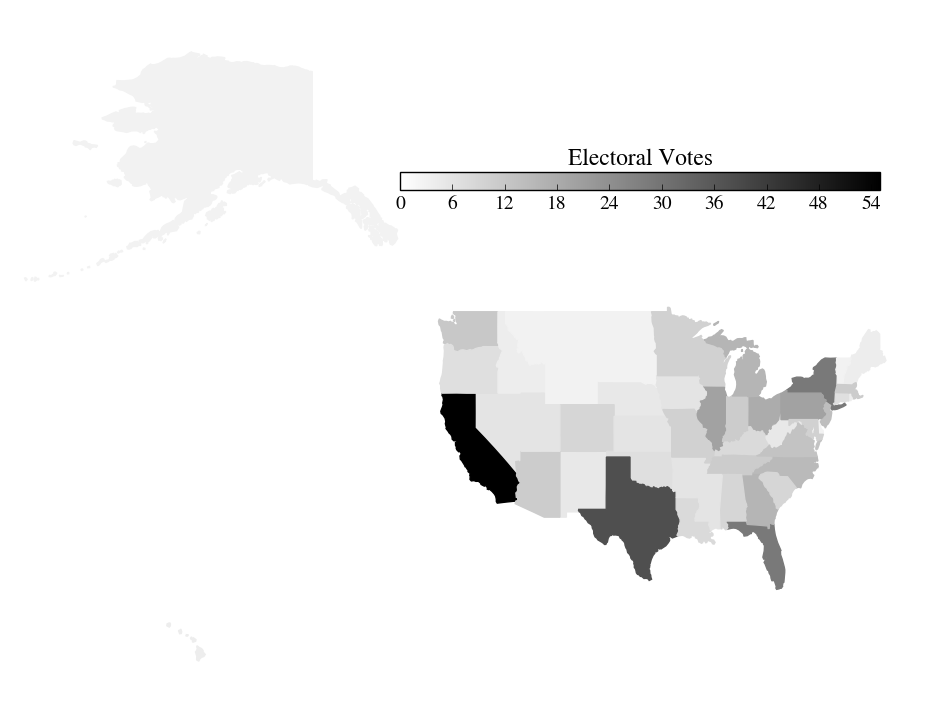

In [6]:
## ilustrate the vote by make_map
make_map(electoral_votes.Votes,"Electoral Votes")

### 4. A function that simulates the outcome of the prediction given the dataframe of probability (helpers)

In [7]:
### Use Bernoulli distribution (Binomial distribution with n =1)
def simulate_election(model,n_sim):
    states = model.index
    # results is an array that carries the total electoral vote Trump wins in each iteration
    results = []
    for i in range (n_sim):
        # for each iteration, we perform Bernoulli sampling to see if Trump wins a specific state
        electoral_won = []
        for state in states:
            # query wining percentage 
            p = model.ix[str(state), "Trump"]
            s = np.random.binomial(1, p, 1)
            if s[0] == 1:
                electoral_won.append(model.ix[str(state),"Votes"])
        results.append(sum(electoral_won))
    return results

### 5. Function that plots the simulation in a density chart

In [8]:
def prob_win (simulation):
    prob = (float(sum([1 for i in simulation if i>=269]))/10000)*100
    return prob

def plot_simulation (simulation):
    prob = prob_win (simulation)
    lowerpercentile = int(np.percentile (simulation,5)) #5% percentile
    higherpercentile = int(np.percentile(simulation,95)) # 95% percentile
    title = "Chance of Trump Victory: "+str(prob) + "%, " + "Spread: "+ str(higherpercentile -lowerpercentile) + " votes"
    ## use normed to draw probability function
    
    plt.hist(simulation, bins = np.arange (min(simulation),max(simulation)+1,1),normed = True, label ="simulation", align='left')
    plt.xlabel("Trump Toal Electoral College vote")
    plt.ylabel('Probability')
    plt.title(title)
    plt.axvline (269,0,0.5,color ='k', label = "Victory Threshold: 269")
    plt.axvline (306,0,0.5,color ='r', label = "Actual Outcome: 306")
    plt.legend(frameon = False, loc ='upper left')
    remove_border()

## Part 1: Finding Probability of Trump wining in each state by linear regression on Washington pre-election poll

In [9]:
washington_16=pd.read_csv("election_data/washington_poll.csv").set_index('State')
washington_16["Rep_Adv"] = washington_16.Trump - washington_16.Clinton
washington_16["Unknown"] = 100 - washington_16.Trump - washington_16.Clinton

washington_16.head()

,Clinton,Trump,Rep_Adv,Unknown
State,,,,
Wyoming,21,57,36,22
Alaska,31,38,7,31
Montana,31,44,13,25
North Dakota,26,51,25,23
South Dakota,29,43,14,28


##### Estimate bias from 2012 election

In [10]:
#### We uses data from the 2008 Election
washington_12 = pd.read_csv("election_data/w12.csv").set_index('State')
results_12 = pd.read_csv("election_data/2012results.csv").set_index("State")

prediction_12 = washington_12[["Rep_Adv"]]
prediction_12["Rep_Win"]=results_12["Rep_Pct"]-results_12["Dem_Pct"]
prediction_12.head()

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Rep_Adv,Rep_Win
State,,
Alabama,13.6,14.0
Alaska,8.4,22.1
Arizona,7.5,9.1
Arkansas,-0.7,23.7
California,-13.7,-23.1


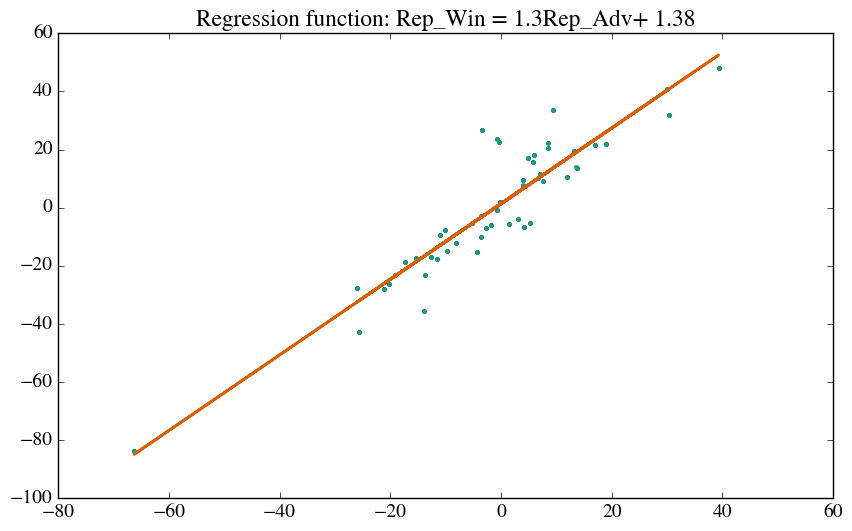

In [11]:
##Make a scatter plot using the prediction_12 dataframe of the democratic advantage in the 2012 Wahington post poll (X axis) compared to the republican win percentage -- the difference between Romney and Obama's vote percentage -- in the election (Y Axis)

plt.scatter(prediction_12["Rep_Adv"], prediction_12["Rep_Win"])
m,b= np.polyfit (prediction_12["Rep_Adv"], prediction_12["Rep_Win"], 1)
title = "Regression function: Rep_Win = " + str(round(m,2)) + "Rep_Adv+ " + str(round(b,2))
plt.title (title)
plt.plot(prediction_12["Rep_Adv"], prediction_12["Rep_Win"], '.')
plt.plot(prediction_12["Rep_Adv"], m*prediction_12["Rep_Adv"]+b, '-')

In [12]:
## List the state that showed Democratic Advantage but vote Republican

prediction_12[(prediction_12.Rep_Adv<0) & (prediction_12.Rep_Win>0)]

,Rep_Adv,Rep_Win
State,,
Arkansas,-0.7,23.7
Kentucky,-0.4,22.7
North Carolina,-0.2,2.0
West Virginia,-3.4,26.8


In [13]:
###Subtracts a fixed amount from Rep_Adv, beofore computing the uncertain_washington_model.
# This simulates correcting a hypothetical bias towards Republican
def biased_washington (df, bias):
    adjust_result = []
    for state in df.index:
        adjust = float(df.ix[str(state),"Rep_Adv"]) - bias
        adjust_result.append(adjust)
    result = pd.DataFrame({"Rep_Adv":adjust_result}, index = df.index)
    return result

"""
Function
--------
uncertain_model

A forecast that predicts an Republican victory if the random variable drawn
from a Gaussian with mean Rep_Adv and sd 3% is >0

"""
import math
from scipy.special import erf
def uncertain_model (df):
    sigma = 3
    Rep = []
    for state in df.index:
        mean = float(df.ix[str(state),"Rep_Adv"])
        prob = 0.5*(1+erf((mean)/math.sqrt(2*(sigma**2))))
        Rep.append(prob)
    result = pd.DataFrame({"Trump":Rep}, index = df.index)
    return result    

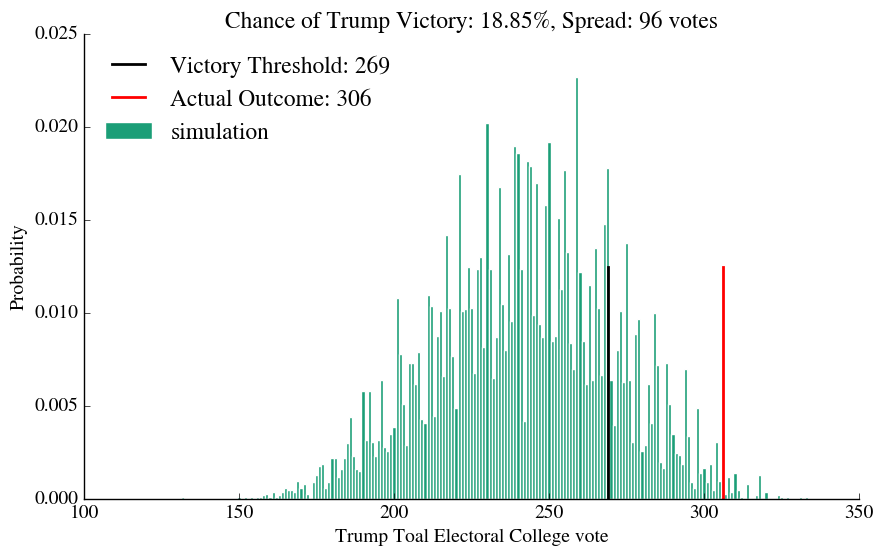

In [14]:
## our bias constant is the mean of all bias (difference between prediction and actual)
mean_bias = (prediction_12.Rep_Adv - prediction_12.Rep_Win).mean()
model = biased_washington(washington_16, mean_bias)
model = uncertain_model(model)
model = model.join(electoral_votes)
# simulate 10,000 times
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

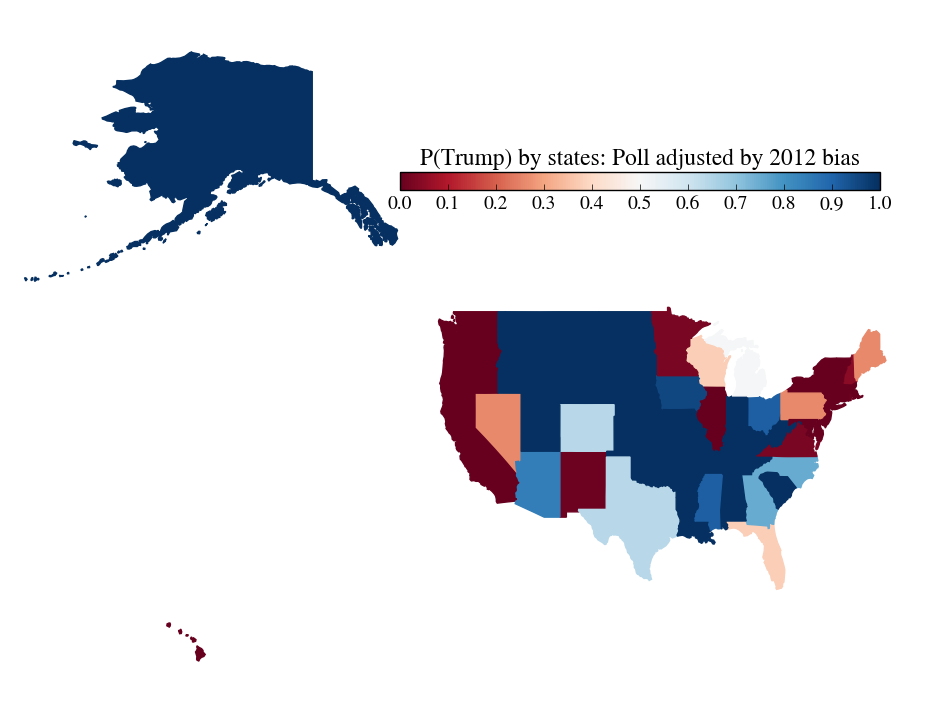

In [15]:
make_map(model.Trump, "P(Trump) by states: Poll adjusted by 2012 bias")

In [16]:
## mean of total Electoral Votes Trump will get
np.mean(prediction)

241.90209999999999

In [17]:
np.median(prediction)

243.0

## Part 2:  Bayesian inference using Metropolis-Hasting (Gibbs sampling) to find probability of Trump winning in each state



In [18]:
#### This table aggregates many of the pre-election polls

# index_col = False to avoid using the first column as index
multipoll = pd.read_csv('election_data/data.csv', index_col=False)

#convert dates from strings to date objects, and compute midpoint
multipoll.startdate = multipoll.startdate.apply(pd.to_datetime)
multipoll.enddate = multipoll.enddate.apply(pd.to_datetime)
multipoll['poll_date'] = multipoll.startdate + (multipoll.enddate - multipoll.startdate).values / 2

#drop unneeded columns
multipoll = multipoll.drop(['cycle','branch','matchup','forecastdate','grade', 'population', 'poll_wt', 'rawpoll_johnson', 'rawpoll_mcmullin'
                           ,'adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url', 'question_id'
                           ,'createddate', 'timestamp'], axis=1)
#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]


## remove all the polls whose state is "U.S."
multipoll = multipoll[multipoll.State!='U.S.']
## drop all the duplicated polls
multipoll = multipoll.drop_duplicates('poll_id')
#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')


#drop rows with missing data along the row
multipoll = multipoll.dropna(0, 'any')

multipoll.head()


,type,State,startdate,enddate,pollster,samplesize,rawpoll_clinton,rawpoll_trump,poll_id,poll_date,age_days,Votes
380,polls-plus,North Carolina,2016-09-29,2016-10-02,Selzer & Company,805.0,44.0,43.0,46385,2016-09-30 12:00:00,7.5,15.0
384,polls-plus,Pennsylvania,2016-10-03,2016-10-06,Marist College,709.0,49.0,37.0,46567,2016-10-04 12:00:00,3.5,20.0
387,polls-plus,Wisconsin,2016-10-05,2016-10-07,YouGov,993.0,43.0,39.0,46569,2016-10-06 00:00:00,2.0,10.0
413,polls-plus,Ohio,2016-10-05,2016-10-06,Public Policy Polling,782.0,44.0,43.0,46540,2016-10-05 12:00:00,2.5,18.0
436,polls-plus,Vermont,2016-09-29,2016-10-14,Castleton University,579.0,45.0,17.0,47069,2016-10-06 12:00:00,1.5,3.0


In [19]:
# calculate number of people voting for Trump in each poll (to use in Binomial likelihood function)
multipoll['Trump_voters'] = np.floor((multipoll['samplesize'] / 100) * multipoll['rawpoll_trump'])

In [20]:
# After we have cleaned all data, looks how small our usuable data is. 
# Only 1/10 of the original data
multipoll[["poll_id"]].count()

poll_id    1525
dtype: int64

In [21]:
# create separate csv files for each state having all polls in that state
for state in electoral_votes.index:
    frame = multipoll[multipoll.State == state]
    path = 'poll_by_state/' + state + '.csv'
    frame.to_csv(path, sep=',', float_format='%.1f')

### Now let R do the calculation of Bayesian posterior

In [22]:
## Now that Baysian_MCMC.R has perform iteration using Metropolis-Hasting
## posterior probability that Trump wins in each state is stored in "election_data/bayesian_data"
bayes = pd.read_csv('election_data/bayesian_data.csv').set_index("State")
bayes.head()

,Unnamed: 0,Trump
State,,
California,1,0.155766
Texas,2,0.398392
New York,3,0.261343
Florida,4,0.521740
Illinois,5,0.408512


In [23]:
bayes = bayes.join(electoral_votes)
bayes.head()

,Unnamed: 0,Trump,Votes
State,,,
California,1,0.155766,55
Texas,2,0.398392,38
New York,3,0.261343,29
Florida,4,0.521740,29
Illinois,5,0.408512,20


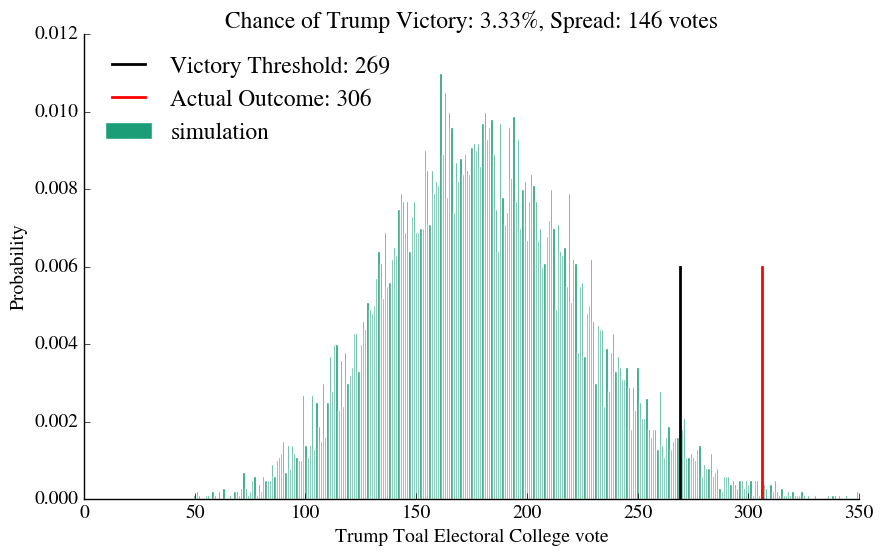

In [24]:
prediction = simulate_election(bayes, 10000)
plot_simulation(prediction)

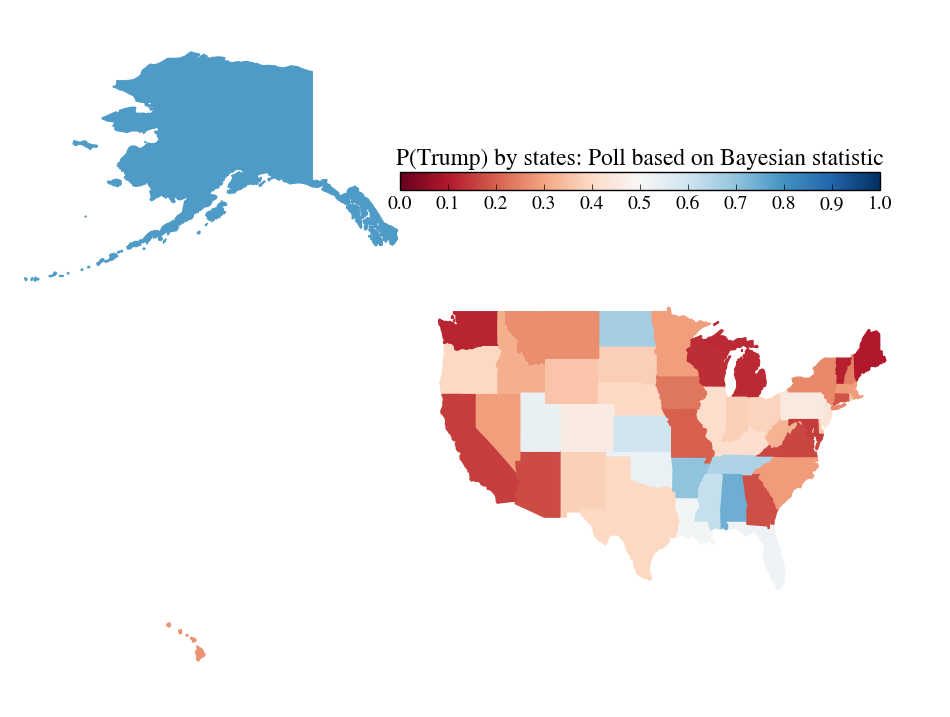

In [25]:
make_map(bayes.Trump, "P(Trump) by states: Poll based on Bayesian statistic")

In [26]:
np.mean(prediction)
### surprisingly low result

181.15360000000001

In [27]:
np.median(prediction)

179.0